In [657]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import integrate

In [258]:
%matplotlib inline
plt.style.use("ggplot")

In [ ]:
def generate_prisoners_dilemma_payoffs(random_state, max_payoff=10):
    T = random_state.randint(3, max_payoff)
    R = random_state.randint(2, T)
    P = random_state.randint(1, R)
    S = random_state.randint(P)
    payoffs = np.array([[R, S], [T, P]])
    return payoffs


def generate_stag_hunt_payoffs(random_state, max_payoff=10):
    T = random_state.randint(3, max_payoff)
    R = random_state.randint(2, T)
    S = random_state.randint(1, R)
    P = random_state.randint(S)
    payoffs = np.array([[R, S], [T, P]])
    return payoffs

In [755]:
def kirkpatrick_selection(x_A, d=1):
    return d * x_A / (1 + (d - 1) * x_A)

def seger_selection(x_A, d=0):
    return x_A * (1 + d * (1 - x_A))

In [582]:
# axis 0 is indexed by male genotype; axis 1 is indexed by female genotype; axis 2 is indexed by offspring genotype
R = np.array([[[1, 1/2, 1/2, 1/4],
               [1/2, 0, 1/4, 0],
               [1/2, 1/4, 0, 0],
               [1/4, 0, 0, 0]],
              [[0, 1/2, 0, 1/4],
               [1/2, 1, 1/4, 1/2],
               [0, 1/4, 0, 0],
               [1/4, 1/2, 0, 0]],
              [[0, 0, 1/2, 1/4],
               [0, 0, 1/4, 0],
               [1/2, 1/4, 1, 1/2],
               [1/4, 0, 1/2, 0]],
              [[0, 0, 0, 1/4],
               [0, 0, 1/4, 1/2],
               [0, 1/4, 0, 1/2],
               [1/4, 1/2, 1/2, 1]]])

In [798]:
def generalized_sexual_selection(x, UGA, UgA, payoff_kernel, number_of_potential_mates=2):
    number_of_genotypes = 4
    assert x.shape == (number_of_genotypes, 1)
    
    # mating probabilities are frequency dependent
    x_A, x_a = np.sum(x[::2]), np.sum(x[1::2])
    assert np.allclose(x_a, 1 - x_A, atol=1e-6), "1-x_A should equal x_a; actual difference is {}".format(1 - x_A - x_a)
    
    # determine the payoffs
    Pi = np.tile(payoff_kernel, (2, 2))
    
    # determine the shares of a particular genotype in the alpha(k) phenotype
    S = np.tile(x, number_of_genotypes).T / np.array([x_A, x_a, x_A, x_a])
    assert np.allclose(np.ones(number_of_genotypes), S[:, ::2].sum(axis=1))
    assert np.allclose(np.ones(number_of_genotypes), S[:, 1::2].sum(axis=1))

    # determine mate selection probabilities
    phenotype_selection_probabilities = np.vstack((np.tile(np.array([UGA(x_A), 1 - UGA(x_A)]), (2,2)),
                                                   np.tile(np.array([UgA(x_A), 1 - UgA(x_A)]), (2,2))))
    genotype_selection_probabilities = S * phenotype_selection_probabilities
    U = np.tile(genotype_selection_probabilities , (number_of_potential_mates, 1, 1))
    U = U[:, :, :, np.newaxis] # insert additional axis for correct broadcasting...
    
    # actual mate selection: female selects one particular male to mate with!
    uniform_random_mate_selection = lambda mates: np.sum(mates / mates.size)
    V = np.apply_along_axis(uniform_random_mate_selection, axis=0, arr=U)
    
    # define the replicator equation
    W = R * V * Pi
    offspring_by_genotype = W.sum(axis=0).dot(x)
    total_offspring = offspring_by_genotype.sum(axis=0)
    x_dot = (offspring_by_genotype / total_offspring) - x
    assert np.allclose(x_dot.sum(), 0.0, atol=1e-6), "Derivatives should sum to one; acual sum is {}".format(x_dot.sum())
    
    return x_dot

In [799]:
prng = np.random.RandomState(42)
payoff_kernel = generate_prisoners_dilemma_payoffs(prng)

In [800]:
d = 1.5
UGA = lambda x_A: kirkpatrick_selection(x_A, d)
UgA = lambda x_A: kirkpatrick_selection(x_A, d)

In [801]:
y0, = prng.dirichlet(np.ones(number_of_genotypes), 1)
f = lambda t, y: generalized_sexual_selection(y, UGA, UgA, payoff_kernel)

In [802]:
# confirm equilibrium with all GA
eps = 1e-12
equilibrium = np.array([1-eps, 0, 0, eps])
assert np.allclose(f(0, equilibrium.reshape(-1, 1)), np.zeros(number_of_genotypes).reshape(-1,1))

In [803]:
# confirm equilibrium with all ga
eps = 1e-12
equilibrium = np.array([eps, 0, 0, 1-eps])
assert np.allclose(f(0, equilibrium.reshape(-1, 1)), np.zeros(number_of_genotypes).reshape(-1,1))

# Basic simulation

In [738]:
integrate.solve_ivp?

In [739]:
y0, = prng.dirichlet(np.ones(number_of_genotypes), 1)
f = lambda t, y: model(y, UGA, UgA, prisoners_dilemma_payoffs)
result = integrate.solve_ivp(f, t_span=(0, 10), y0=y0, rtol=1e-7, atol=1e-9, dense_output=True, vectorized=True)

In [740]:
result

  message: 'The solver successfully reached the interval end.'
     nfev: 218
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x1517b67dd8>
   status: 0
  success: True
        t: array([  0.        ,   0.03277593,   0.3605352 ,   1.55138812,
         2.38867607,   2.84213827,   3.23710336,   3.58869473,
         3.9426338 ,   4.2458227 ,   4.55081584,   4.85580897,
         5.16080211,   5.43447692,   5.70894156,   5.9834062 ,
         6.25787084,   6.53233547,   6.80799861,   7.08667796,
         7.36936068,   7.65714885,   7.95128647,   8.25320685,
         8.56456956,   8.88729027,   9.22356882,   9.57592261,
         9.94723358,  10.        ])
 t_events: None
        y: array([[  7.23778579e-02,   7.16802049e-02,   6.46225195e-02,
          3.92131931e-02,   2.40360652e-02,   1.75269481e-02,
          1.29584162e-02,   9.72137688e-03,   7.17071035e-03,
          5.47084146e-03,   4.13629346e-03,   3.10865583e-03,
          2.32539005e-03,   

In [705]:
# sanity check that the simulated trajectory satisfies adding up constraint
assert np.allclose(result.y.sum(axis=0), np.ones(result.t.size))

# Interactive simulation

In [810]:
def plot_generalized_sexual_selection(x0=0.25, x1=0.25, x2=0.25, selection_function="kirkpatrick",
                                      d0=1, d2=1, T=10, R=6, P=4, S=0, max_time=10):

    fig, ax = plt.subplots(1,1, figsize=(10,8))

    # prepare the axes
    ax.set_ylim((0, 1))
    ax.set_xlabel(r"Time, $t$", fontsize=15)
    ax.set_ylabel(r"Female genotype shares, $x_i$", fontsize=15)
    
    # create the initial condition
    x3 = 1 - (x0 + x1 + x2)
    y0=np.array([x0,x1,x2,x3])
    assert np.allclose(y0.sum(), 1)
    
    # create the payoff kernel
    assert T > R > P > S
    payoff_kernel = np.array([[R, S],
                              [T, P]])
    
    # create the selection functions
    if selection_function == "kirkpatrick":
        UGA = lambda x_A: kirkpatrick_selection(x_A, d0)
        UgA = lambda x_A: kirkpatrick_selection(x_A, d2)
    elif selection_function == "seger":
        UGA = lambda x_A: seger_selection(x_A, d0)
        UgA = lambda x_A: seger_selection(x_A, d2)
    else:
      raise ValueError("selection_function must be one of \"kirkpatrick\" or \"seger\".")
    
    # simulate the model starting from a random initial condition
    f = lambda t, y: generalized_sexual_selection(y, UGA, UgA, payoff_kernel)
    result = integrate.solve_ivp(f, t_span=(0, max_time), y0=y0, rtol=1e-7, atol=1e-9,
                                 dense_output=True, vectorized=True)
    
    ax.plot(result.t, result.y[0], label="GA")
    ax.plot(result.t, result.y[1], label="Ga")
    ax.plot(result.t, result.y[2], label="gA")
    ax.plot(result.t, result.y[3], label="ga")
    ax.legend()
    plt.show()

    return result

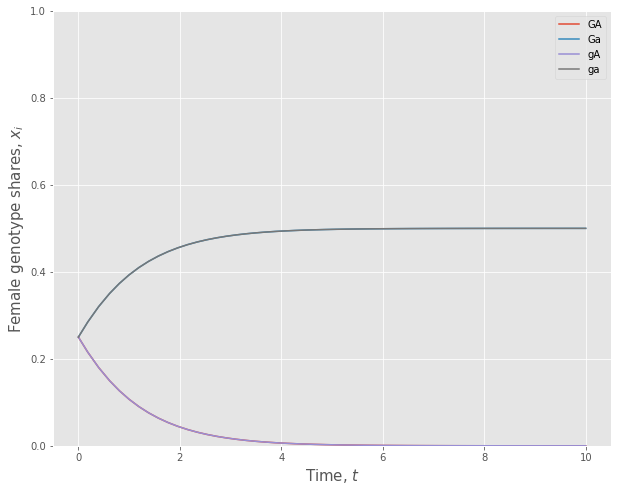

In [811]:
result = plot_generalized_sexual_selection(selection_function="kirkpatrick", T=50)

In [815]:
# sliders used to control the initial condition
x0_slider = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.01, description=r"$x_0$")
x1_slider = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.01, description=r"$x_1$")
x2_slider = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.01, description=r"$x_2$")

# sliders used to control the Prisoner's Dilemma Payoffs
T_slider = widgets.IntSlider(value=10, min=0, max=100, description=r"$T$")
R_slider = widgets.IntSlider(value=8, min=0, max=100, description=r"$R$")
P_slider = widgets.IntSlider(value=6, min=0, max=100, description=r"$P$")
S_slider = widgets.IntSlider(value=4, min=0, max=100, description=r"$S$")

# slider used to control which selection function is being used
U_slider = widgets.Dropdown(options=["kirkpatrick", "seger"], index=0, description=r"$U$")

# slider that controls the parameters of the selection function
d0_slider = widgets.IntSlider(value=1, min=1, max=100, description=r"$d_0$")
d2_slider = widgets.IntSlider(value=1, min=1, max=100, description=r"$d_2$")

# slider that controls max simulation time
max_time_slider = widgets.IntSlider(value=25, min=1, max=250, description=r"$\max t$")

w = widgets.interactive(plot_generalized_sexual_selection, x0=x0_slider, x1=x1_slider, x2=x2_slider,
                        selection_function=U_slider, d0=d0_slider, d2=d2_slider, 
                        T=T_slider, R=R_slider, P=P_slider, S=S_slider, max_time=max_time_slider)
display(w)

A Jupyter Widget